# **Time Series Prediction with LSTM Using PyTorch**

This kernel is based on *datasets* from

[Time Series Forecasting with the Long Short-Term Memory Network in Python](https://machinelearningmastery.com/time-series-forecasting-long-short-term-memory-network-python/)

[Time Series Prediction with LSTM Recurrent Neural Networks in Python with Keras](https://machinelearningmastery.com/time-series-prediction-lstm-recurrent-neural-networks-python-keras/)

## Reference
- https://colab.research.google.com/github/dlmacedo/starter-academic/blob/master/content/courses/deeplearning/notebooks/pytorch/Time_Series_Prediction_with_LSTM_Using_PyTorch.ipynb

## **Download Dataset**

In [1]:
#!wget https://raw.githubusercontent.com/jbrownlee/Datasets/master/shampoo.csv

In [2]:
data_path = 'timeline_diagnosed.csv'
# !wget https://raw.githubusercontent.com/jbrownlee/Datasets/master/airline-passengers.csv

## **Import Packages**

In [3]:
# For data preprocess
import os
import csv
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

# For plotting
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

# Pytorch
import torch
import torch.nn as nn
from torch.autograd import Variable

## **Set Random Seed**

In [4]:
def same_seeds(seed):
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)  
    np.random.seed(seed)  
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

## **Get GPU Resource**

In [5]:
def get_device():
    ''' Get device (if GPU is available, use GPU) '''
    return 'cuda' if torch.cuda.is_available() else 'cpu'
device = get_device()
print(device)

cpu


## **Setup Hyper-parameters**

In [6]:
# data selection
start_date = "2022-03-10"
train_ratio = 0.9
test_ratio = 1 - train_ratio
seq_length = 7

city_codes = ["KEE", "NWT", "TPE", "TAO", "HSZ", "HSQ", "MIA", "TXG", "CHA", "NAN", "YUN", "CYQ", "CYI", "TNN", "KHH", "PIF", "ILA", "HUA", "TTT", "PEN", "KIN", "LIE", "TW"]
# city_codes = ["NWT", "TPE", "TXG", "KHH", "TTT", "PEN", "TW"]

# model parameters
num_epochs = 12000
early_stop = 4000
learning_rate = 0.01

input_size = 1
hidden_size = 3
num_layers = 1
num_classes = 1

criterion = torch.nn.MSELoss()    # mean-squared error for regression
#optimizer = torch.optim.SGD(lstm.parameters(), lr=learning_rate)

# save model
os.makedirs('models', exist_ok=True)
save_path = "models/model-{}.pth"

# others
seed = 12345

## **Check Raw Data**

In [7]:
dataset = pd.read_csv(data_path)
print(dataset)

      city        date  count  accumulateCount
0      KEE  2020-01-28      0                0
1      NWT  2020-01-28      0                0
2      TPE  2020-01-28      0                0
3      TAO  2020-01-28      0                0
4      HSZ  2020-01-28      0                0
...    ...         ...    ...              ...
19683  TTT  2022-06-01    879            15445
19684  PEN  2022-06-01    216             3277
19685  KIN  2022-06-01    145             2582
19686  LIE  2022-06-01     25              665
19687   TW  2022-06-01  76943          2184454

[19688 rows x 4 columns]


In [8]:
def get_city_data(dataset, city, start_date):
    mask = ((dataset["city"] == city) & (dataset["date"] >= start_date))
    city_dataset = dataset[mask]["count"].values.reshape(-1, 1)
    # print(city_dataset)

    # plt.plot(city_dataset, label = 'COVID-19 New Cases')
    # plt.show()
    return city_dataset

## **Preprocessing**

In [9]:
def data_preprocess(city_dataset):
    def sliding_windows(data, seq_length):
        x = []
        y = []

        for i in range(len(data)-seq_length-1):
            _x = data[i:(i+seq_length)]
            _y = data[i+seq_length]
            x.append(_x)
            y.append(_y)

        return np.array(x),np.array(y)

    sc = MinMaxScaler()
    city_data = sc.fit_transform(city_dataset)
    x, y = sliding_windows(city_data, seq_length)

    train_size = int(len(y) * train_ratio)
    test_size = len(y) - train_size

    dataX = Variable(torch.Tensor(np.array(x)))
    dataY = Variable(torch.Tensor(np.array(y)))

    train_indices = [i for i in range(train_size) if i%10 != 7]
    val_indices = [i for i in range(train_size) if i%10 == 7]

    trainX = Variable(torch.Tensor(np.array(x[train_indices])))
    trainY = Variable(torch.Tensor(np.array(y[train_indices])))

    valX = Variable(torch.Tensor(np.array(x[val_indices])))
    valY = Variable(torch.Tensor(np.array(y[val_indices])))

    testX = Variable(torch.Tensor(np.array(x[(train_size): len(x)])))
    testY = Variable(torch.Tensor(np.array(y[(train_size): len(y)])))

    return sc, dataX, dataY, trainX, trainY, valX, valY, testX, testY

## **Model**
LSTM + fully connected layer

In [10]:
class LSTM(nn.Module):

    def __init__(self, num_classes, input_size, hidden_size, num_layers):
        super(LSTM, self).__init__()
        
        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.seq_length = seq_length
        
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True)
        
        self.fc = nn.Linear(hidden_size * num_layers, num_classes)

    def forward(self, x):
        h_0 = Variable(torch.zeros(
            self.num_layers, 
            x.size(0), 
            self.hidden_size,
            device=device))
        
        c_0 = Variable(torch.zeros(
            self.num_layers,
            x.size(0),
            self.hidden_size,
            device=device))
        
        # Propagate input through LSTM
        ula, (h_out, _) = self.lstm(x, (h_0, c_0))
        
        h_out = h_out.view(-1, self.hidden_size * self.num_layers)
        
        out = self.fc(h_out)
        
        return out

# **Train/Test**

## **Training**

In [11]:
def train(city, model, trainX, trainY, valX, valY):
    min_loss = np.infty
    loss_record = {'train': [], 'val': []}
    early_stop_cnt = 0
    _trainX, _trainY = trainX.to(device), trainY.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    for epoch in range(num_epochs):
        model.train()
        optimizer.zero_grad()

        pred = model(_trainX)
        
        # obtain the loss function
        loss = criterion(pred, _trainY)
        loss.backward()
        optimizer.step()
        loss_record['train'].append(loss.detach().cpu().item())

        val_loss = val(model, valX, valY)
        if val_loss < min_loss:
            min_loss = val_loss
            # print('Saving {} model (epoch = {:4d}, val loss = {:.4f})'
            #     .format(city, epoch + 1, min_loss))
            torch.save(model.state_dict(), save_path.format(city))
            early_stop_cnt = 0
        else:
            early_stop_cnt += 1

        loss_record['val'].append(val_loss)

        if (epoch+1) % 100 == 0:
            print("Epoch: %d, loss: %1.5f, %1.5f" % (epoch+1, loss.item(), val_loss))
        if early_stop_cnt > early_stop:
            break
    
    return min_loss, loss_record

## **Validation**

In [12]:
def val(model, valX, valY):
    model.eval()
    _valX, _valY = valX.to(device), valY.to(device)
    with torch.no_grad():
        pred = model(_valX)
        loss = criterion(pred, _valY)
    total_loss = loss.detach().cpu().item()

    return total_loss

## **Train for Cities**

In [13]:
loss_record = {}

for city in city_codes:
    same_seeds(seed)
    print(f"===== {city} =====")
    city_dataset = get_city_data(dataset, city, start_date)
    _, _, _, trainX, trainY, valX, valY, _, _ = data_preprocess(city_dataset)
    
    lstm = LSTM(num_classes, input_size, hidden_size, num_layers).to(device)

    city_min_loss, city_loss_record = train(city, lstm, trainX, trainY, valX, valY)
    print(f"{city}: min_loss = {city_min_loss}")
    loss_record[city] = city_loss_record
    del lstm

===== KEE =====
Epoch: 100, loss: 0.00374, 0.00101
Epoch: 200, loss: 0.00370, 0.00105
Epoch: 300, loss: 0.00365, 0.00111
Epoch: 400, loss: 0.00360, 0.00118
Epoch: 500, loss: 0.00354, 0.00128
Epoch: 600, loss: 0.00346, 0.00140
Epoch: 700, loss: 0.00337, 0.00150
Epoch: 800, loss: 0.00328, 0.00148
Epoch: 900, loss: 0.00318, 0.00134
Epoch: 1000, loss: 0.00306, 0.00114
Epoch: 1100, loss: 0.00297, 0.00102
Epoch: 1200, loss: 0.00284, 0.00079
Epoch: 1300, loss: 0.00259, 0.00065
Epoch: 1400, loss: 0.00199, 0.00091
Epoch: 1500, loss: 0.00173, 0.00132
Epoch: 1600, loss: 0.00157, 0.00144
Epoch: 1700, loss: 0.00138, 0.00230
Epoch: 1800, loss: 0.00118, 0.00297
Epoch: 1900, loss: 0.00110, 0.00247
Epoch: 2000, loss: 0.00102, 0.00259
Epoch: 2100, loss: 0.00095, 0.00269
Epoch: 2200, loss: 0.00095, 0.00304
Epoch: 2300, loss: 0.00084, 0.00407
Epoch: 2400, loss: 0.00078, 0.00484
Epoch: 2500, loss: 0.00075, 0.00565
Epoch: 2600, loss: 0.00071, 0.00622
Epoch: 2700, loss: 0.00066, 0.00675
Epoch: 2800, loss: 0.

## **Training and Validation Loss**

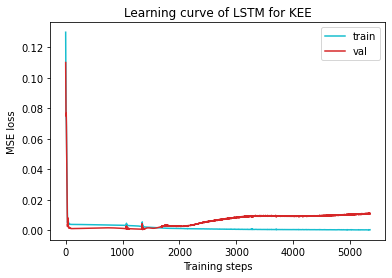

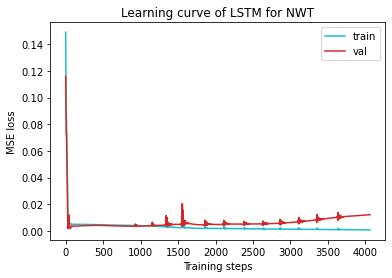

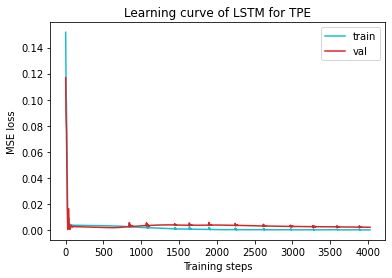

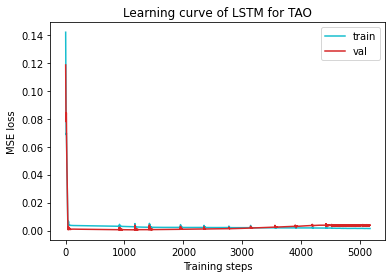

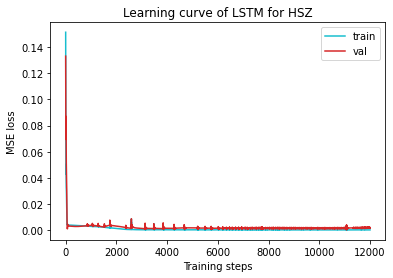

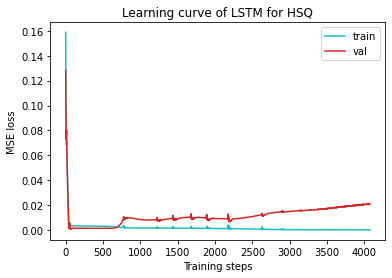

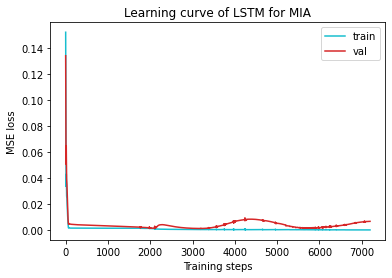

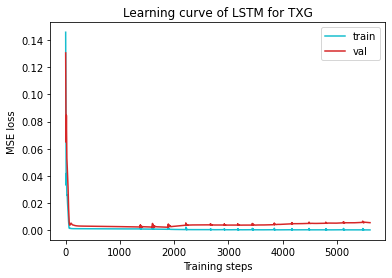

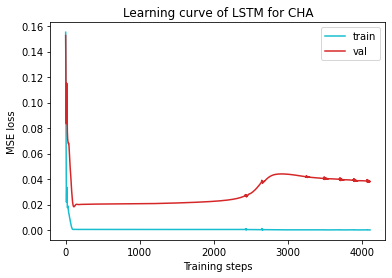

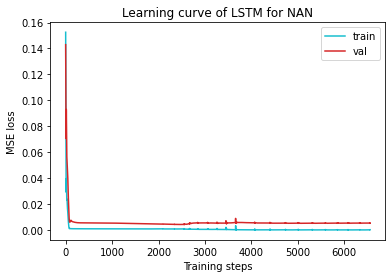

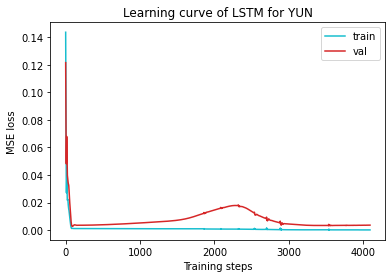

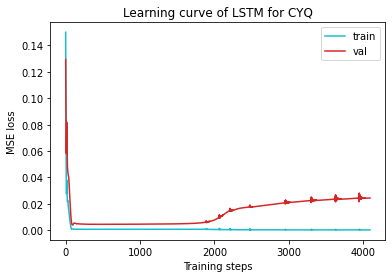

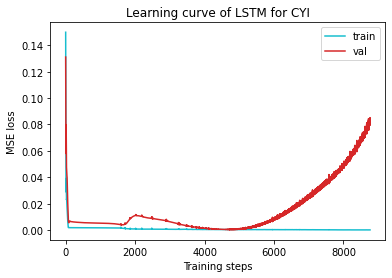

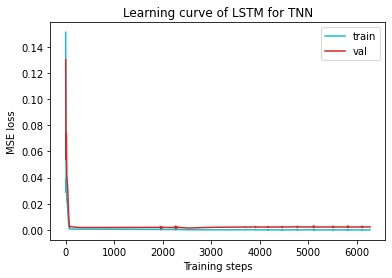

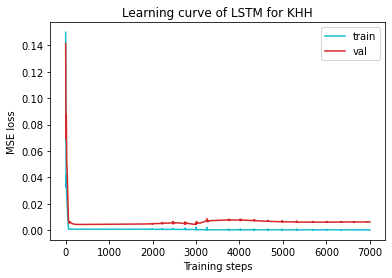

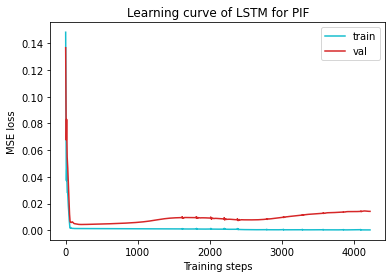

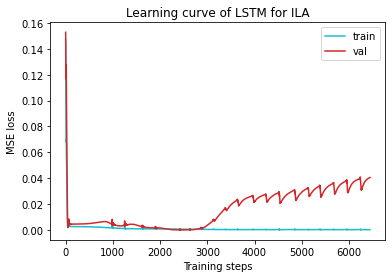

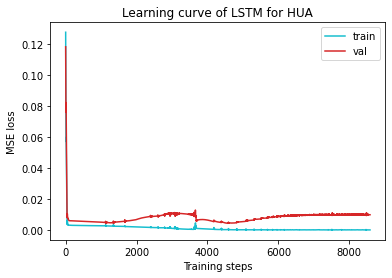

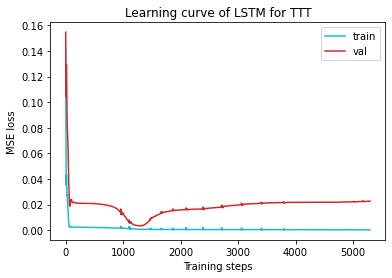

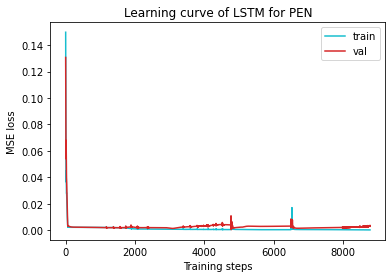

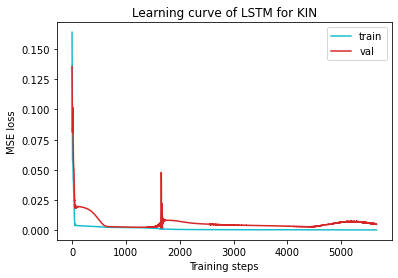

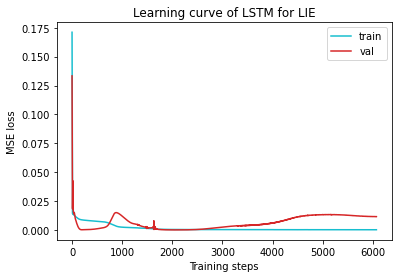

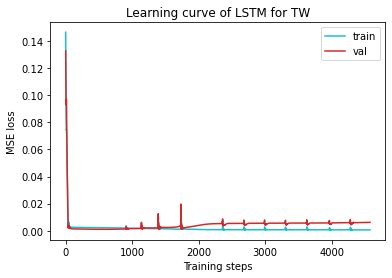

In [14]:
for city in city_codes:
    total_steps = len(loss_record[city]['train'])
    x_1 = range(total_steps)
    x_2 = x_1[::len(loss_record[city]['train']) // len(loss_record[city]['val'])]
    figure(figsize=(6, 4))
    plt.plot(x_1, loss_record[city]['train'], c='tab:cyan', label='train')
    plt.plot(x_2, loss_record[city]['val'], c='tab:red', label='val')
    plt.xlabel("Training steps")
    plt.ylabel("MSE loss")
    plt.title(f"Learning curve of LSTM for {city}")
    plt.legend()
    plt.show()

## **Testing**

Define plotting function.

In [15]:
def plot_predict(city, data_type, pred, real):
    plt.plot(pred)
    plt.plot(real)
    plt.suptitle(f"Time-Series Prediction for {city} {data_type}")
    plt.xlabel(f"Time (days) from {start_date}")
    plt.ylabel("Number of New Cases")
    plt.legend(("predicted", "real"))

    if data_type == "Data":
        train_size = int(len(real) * train_ratio)
        plt.axvline(x=(train_size), c='red', linestyle=':')

    plt.show()

In [16]:
def plot_diff(city, data_type, pred_cities, pred_tw, real):
    plt.plot(pred_cities)
    plt.plot(pred_tw)
    plt.plot(real)

    plt.suptitle(f"Time-Series Prediction for {city} {data_type}")
    plt.xlabel(f"Time (days) from {start_date}")
    plt.ylabel("Number of New Cases")
    plt.legend(("cities", "Taiwan", "real"))

    if data_type == "Data":
        train_size = int(len(real) * train_ratio)
        plt.axvline(x=(train_size), c='red', linestyle=':')

    plt.show()

Test for each city and plot it.

In [17]:
def test(city, model, X, Y):
    model.eval()
    _X, _Y = X.to(device), Y.to(device)
    test_predict = model(_X)
    loss = criterion(test_predict, _Y)
    print(f"loss: {loss.item():1.5f}")

    return test_predict.detach().cpu()

loss: 0.06098


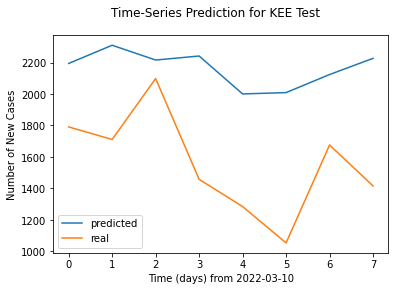

loss: 0.00827


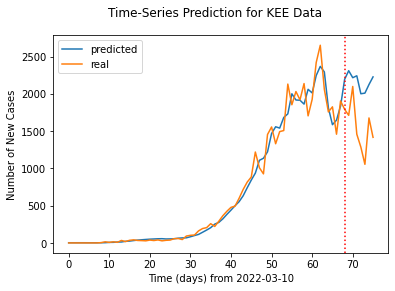

loss: 0.01997


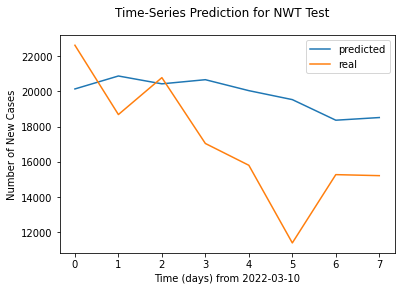

loss: 0.00669


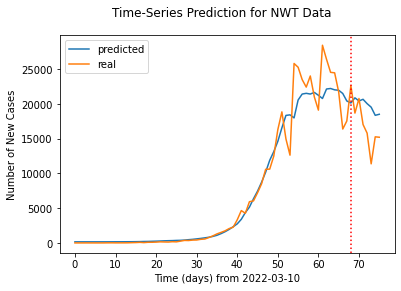

loss: 0.01262


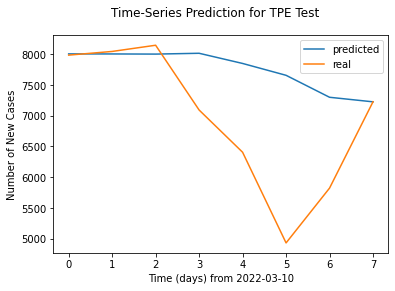

loss: 0.00622


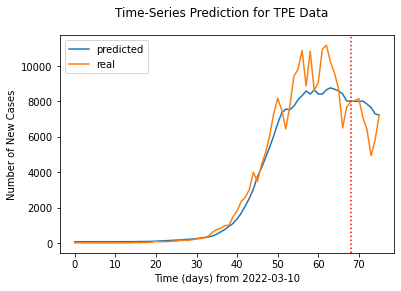

loss: 0.02901


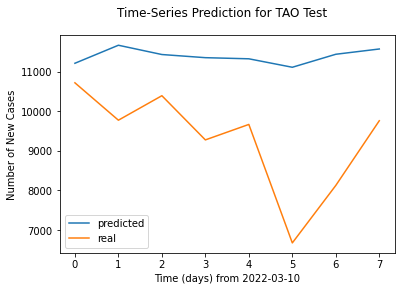

loss: 0.00526


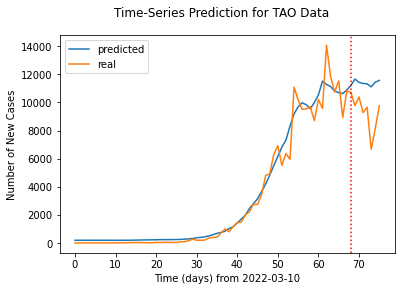

loss: 0.08905


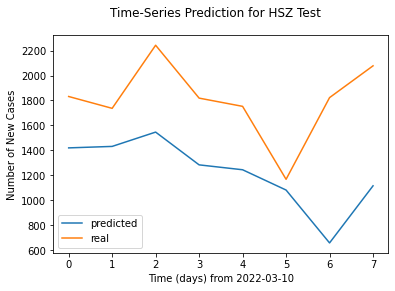

loss: 0.01003


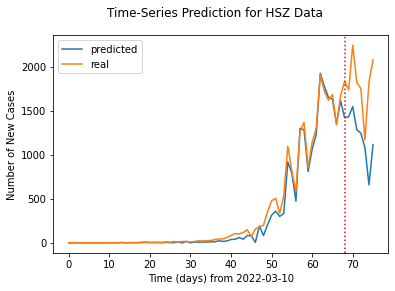

loss: 0.01299


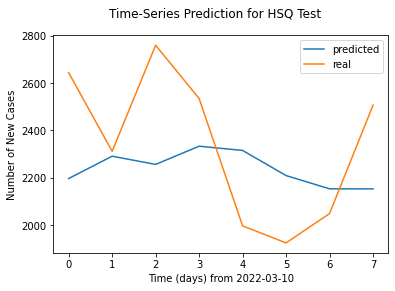

loss: 0.00442


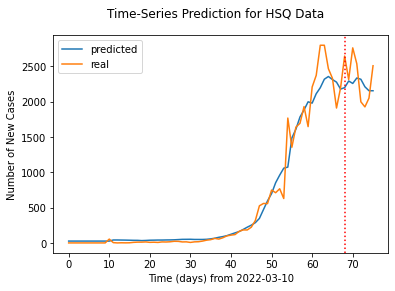

loss: 0.16128


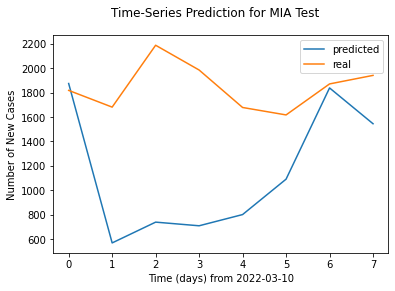

loss: 0.01733


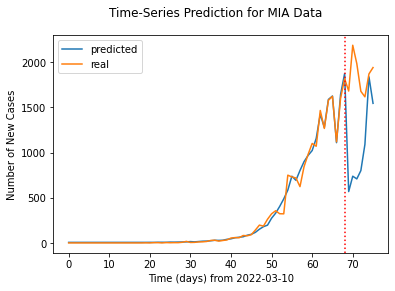

loss: 0.02044


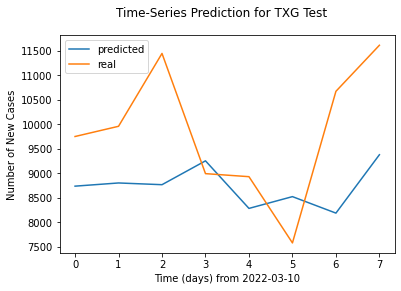

loss: 0.00310


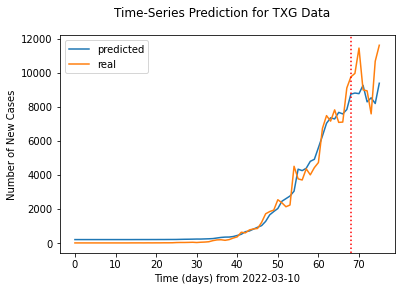

loss: 0.05061


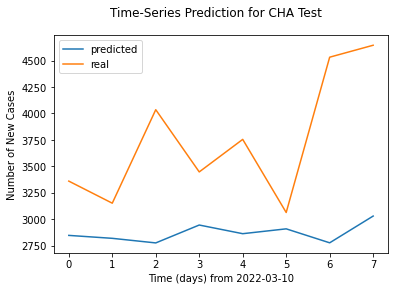

loss: 0.00747


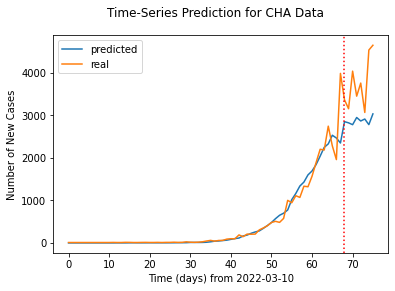

loss: 0.04921


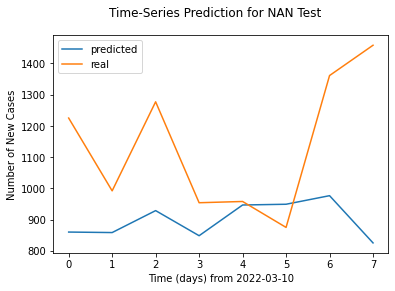

loss: 0.00614


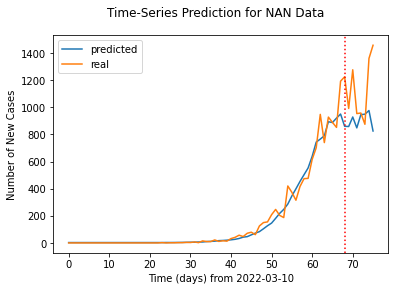

loss: 0.04693


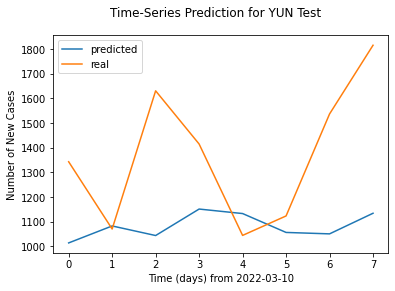

loss: 0.00621


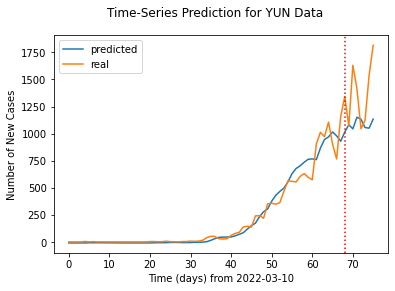

loss: 0.04221


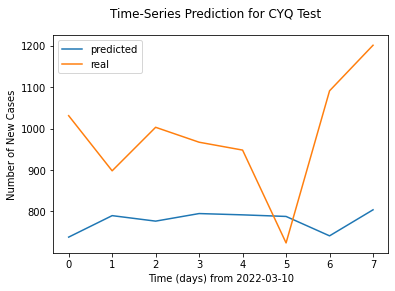

loss: 0.00555


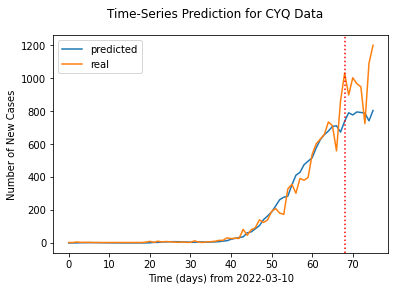

loss: 0.25673


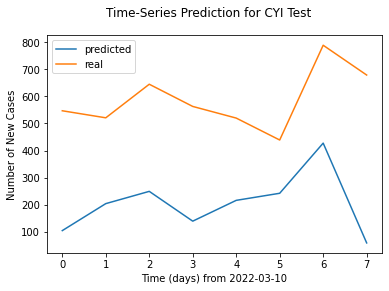

loss: 0.02738


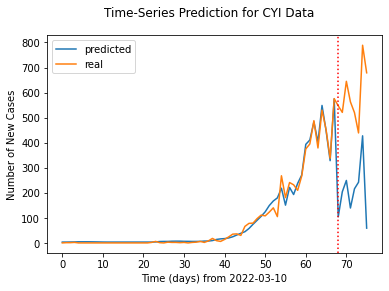

loss: 0.01841


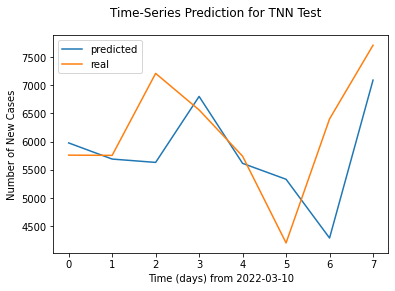

loss: 0.00246


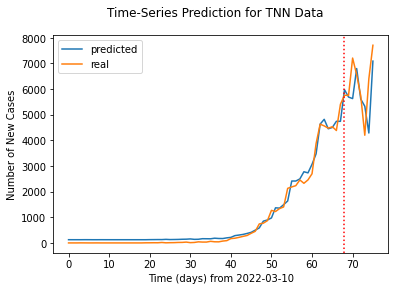

loss: 0.02617


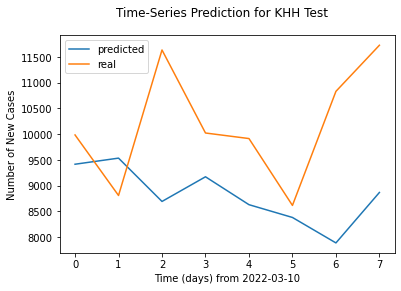

loss: 0.00359


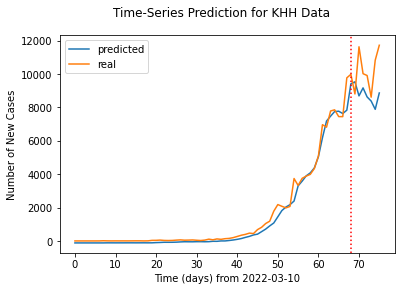

loss: 0.01834


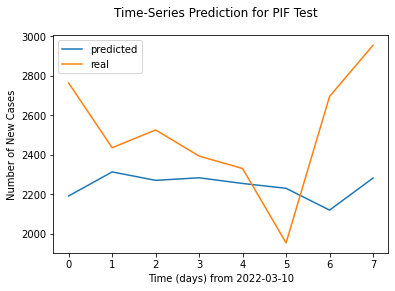

loss: 0.00334


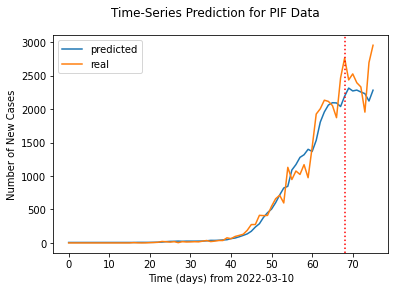

loss: 0.24871


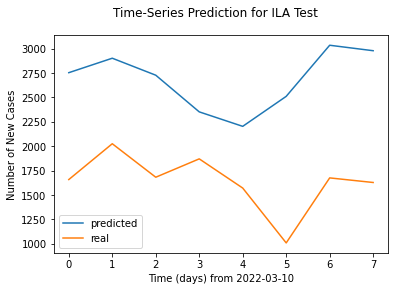

loss: 0.02671


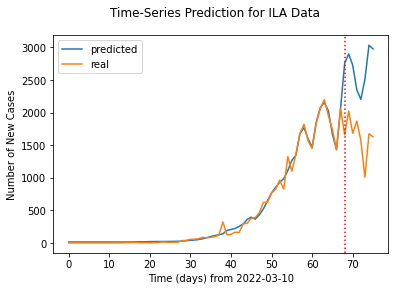

loss: 0.02306


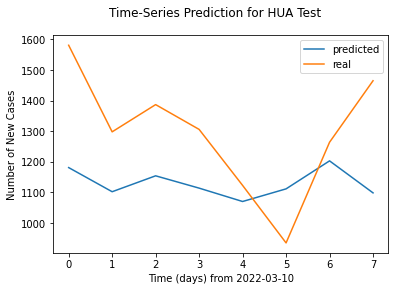

loss: 0.00319


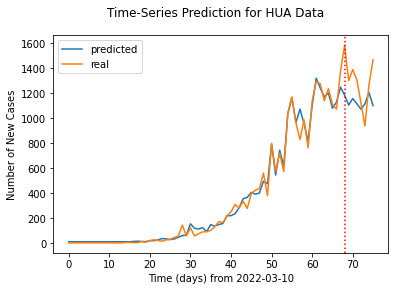

loss: 0.02395


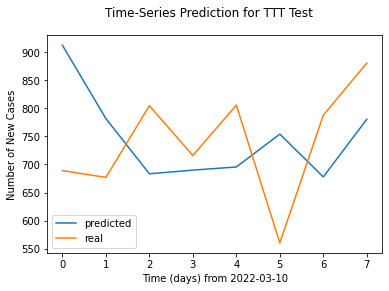

loss: 0.00341


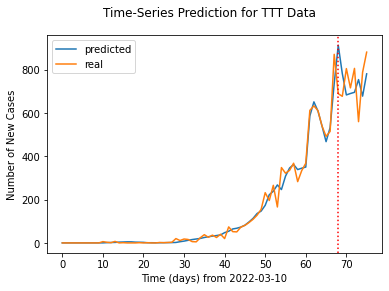

loss: 0.01893


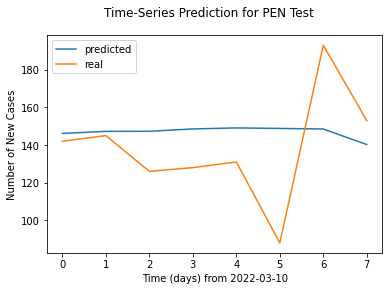

loss: 0.00747


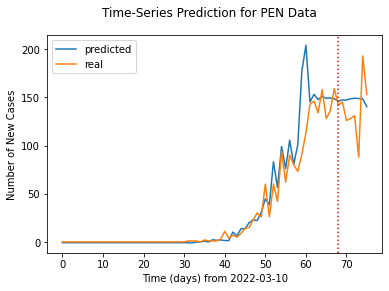

loss: 0.01748


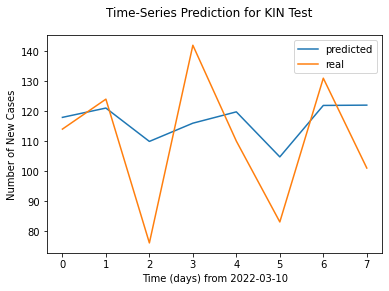

loss: 0.00364


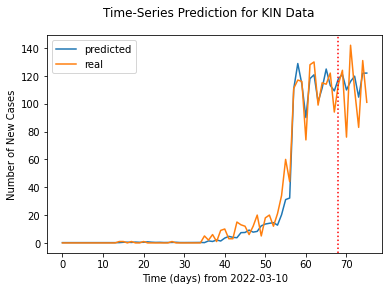

loss: 0.22095


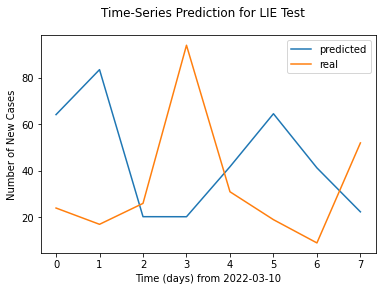

loss: 0.02358


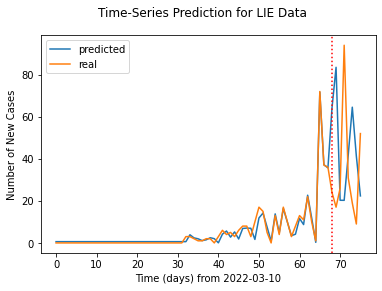

loss: 0.01039


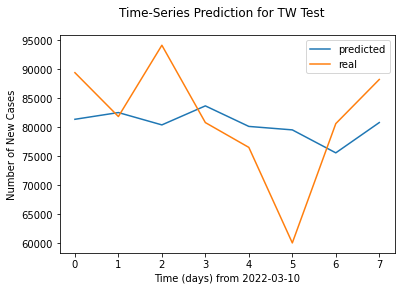

loss: 0.00297


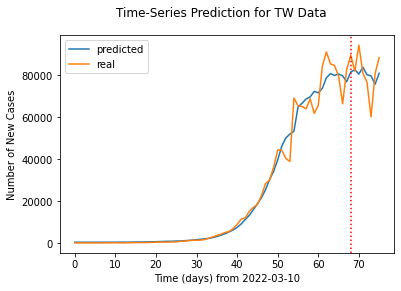

In [18]:
cities_test_pred = 0
tw_test_pred = 0
cities_data_pred = 0
tw_data_pred = 0

test_real = 0
data_real = 0

for city in city_codes:
    lstm = LSTM(num_classes, input_size, hidden_size, num_layers).to(device)
    ckpt = torch.load(save_path.format(city), map_location='cpu')
    lstm.load_state_dict(ckpt)

    city_dataset = get_city_data(dataset, city, start_date)
    sc, dataX, dataY, _, _, _, _, testX, testY = data_preprocess(city_dataset)
    
    # test set
    test_predict = test(city, lstm, testX, testY)
    test_predict = sc.inverse_transform(test_predict.data.numpy())
    testY = sc.inverse_transform(testY.data.numpy())
    plot_predict(city, "Test", test_predict, testY)

    if city == "TW":
        tw_test_pred = test_predict
        test_real = testY
    else:
        cities_test_pred += test_predict

    # train + validation + test set
    data_predict = test(city, lstm, dataX, dataY)
    data_predict = sc.inverse_transform(data_predict.data.numpy())
    dataY = sc.inverse_transform(dataY.data.numpy())
    plot_predict(city, "Data", data_predict, dataY)

    if city == "TW":
        tw_data_pred = data_predict
        data_real = dataY
    else:
        cities_data_pred += data_predict

    del lstm

(test) MSE of new cases in all cities: 8844.2509765625
(test) MSE of new cases of Taiwan:     9596.53125


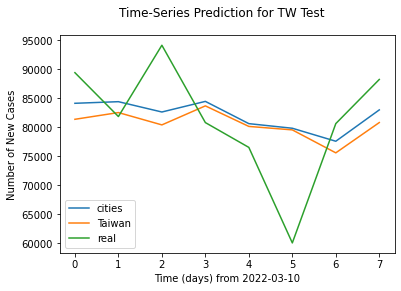

(data) MSE of new cases in all cities: 4680.44970703125
(data) MSE of new cases of Taiwan:     5129.5234375


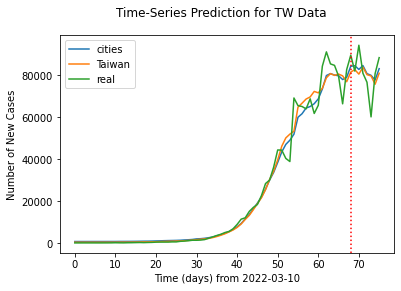

In [19]:
# print(cities_test_pred)
# print(tw_test_pred)
# print(cities_data_pred)
# print(tw_data_pred)

# print(test_real)
# print(data_real)

cities_test_mse = np.sqrt(np.mean(np.power(cities_test_pred - test_real, 2)))
tw_test_mse = np.sqrt(np.mean(np.power(tw_test_pred - test_real, 2)))

cities_data_mse = np.sqrt(np.mean(np.power(cities_data_pred - data_real, 2)))
tw_data_mse = np.sqrt(np.mean(np.power(tw_data_pred - data_real, 2)))

print(f"(test) MSE of new cases in all cities: {cities_test_mse}")
print(f"(test) MSE of new cases of Taiwan:     {tw_test_mse}")
plot_diff(city, "Test", cities_test_pred, tw_test_pred, test_real)

print(f"(data) MSE of new cases in all cities: {cities_data_mse}")
print(f"(data) MSE of new cases of Taiwan:     {tw_data_mse}")
plot_diff(city, "Data", cities_data_pred, tw_data_pred, data_real)